In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [5]:
# load and prepare data
df = pd.read_csv('smartsell.csv')

# Drop unwanted columns
df.drop(columns=['Day', 'IsHoliday'], inplace=True)

# Fill missing values if any
df.fillna(df.median(numeric_only=True), inplace=True)

print("✅ Data loaded and cleaned!")
display(df.head())

✅ Data loaded and cleaned!


,Store,Dept,Weekly_Sales,Month,Week_Number,Holiday_Label,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,22,8998.71,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315
1,1,17,8086.43,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315
2,1,48,1291.00,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315
3,1,55,13677.11,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315
4,1,83,6213.61,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315


In [6]:
# Feature Engineering

# ❗ Add Year column
df['Year'] = 2024 

# Convert Year and Week_Number into actual dates
df['Date'] = df.apply(
    lambda row: pd.to_datetime(f"{row['Year']}-W{int(row['Week_Number']):02d}-1", format="%Y-W%U-%w"),
    axis=1
)

# Now extract Month Name
df['Month'] = df['Date'].dt.month_name()

print("✅ Date and Month generated successfully!")
display(df[['Year', 'Week_Number', 'Date', 'Month']].head())

✅ Date and Month generated successfully!


,Year,Week_Number,Date,Month
0,2024,2,2024-01-15,January
1,2024,2,2024-01-15,January
2,2024,2,2024-01-15,January
3,2024,2,2024-01-15,January
4,2024,2,2024-01-15,January


In [7]:
# Define future holiday dates (Christmas and New Year)
holiday_dates = pd.to_datetime([
    '2025-01-01', '2025-12-25',
    '2026-01-01', '2026-12-25',
    '2027-01-01', '2027-12-25'
])

# Create Holiday_Label based on date
df['Holiday_Label'] = df['Date'].apply(lambda x: 'Holiday' if x.date() in [d.date() for d in holiday_dates] else 'Non-Holiday')

# Add Week_OfYear (same as original Week_Number)
df['Week_OfYear'] = df['Week_Number']

# Display updated dataframe with new features
print("✅ Date, Month, and Holiday_Label generated successfully!")
display(df[['Date', 'Year', 'Month', 'Week_Number', 'Holiday_Label', 'Weekly_Sales']].head())

✅ Date, Month, and Holiday_Label generated successfully!


,Date,Year,Month,Week_Number,Holiday_Label,Weekly_Sales
0,2024-01-15,2024,January,2,Non-Holiday,8998.71
1,2024-01-15,2024,January,2,Non-Holiday,8086.43
2,2024-01-15,2024,January,2,Non-Holiday,1291.00
3,2024-01-15,2024,January,2,Non-Holiday,13677.11
4,2024-01-15,2024,January,2,Non-Holiday,6213.61


In [8]:
display(df.head())

,Store,Dept,Weekly_Sales,Month,Week_Number,Holiday_Label,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Year,Date,Week_OfYear
0,1,22,8998.71,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315,2024,2024-01-15,2
1,1,17,8086.43,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315,2024,2024-01-15,2
2,1,48,1291.00,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315,2024,2024-01-15,2
3,1,55,13677.11,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315,2024,2024-01-15,2
4,1,83,6213.61,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315,2024,2024-01-15,2


In [9]:
# Define features and target
features = [
    'Store', 'Dept', 'Type', 'Size', 'Holiday_Label',
    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Year', 'Month', 'Week_OfYear'
]
target = 'Weekly_Sales'

X = df[features]
y = df[target]

In [10]:
# Build Preprocessing and Model Pipeline
# Preprocess categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Type', 'Holiday_Label', 'Month']),
        ('num', 'passthrough', ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Week_OfYear'])
    ])

# Build pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit model
model.fit(X_train, y_train)
print("✅ Model trained successfully!")

✅ Model trained successfully!


MAE: 4375.14
RMSE: 9281.38


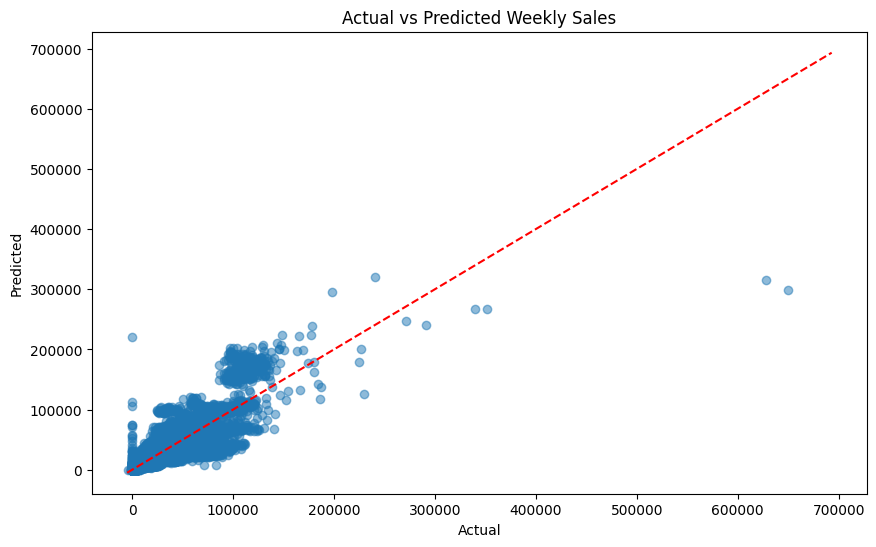

In [11]:
# Evaluate model performance
# Predict on test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Weekly Sales")
plt.show()

In [12]:
# Generate future predictions for 2025-2027
# Get unique combinations of Store and Dept
from itertools import product


store_dept_combos = df[['Store', 'Dept', 'Type', 'Size']].drop_duplicates()

# Generate all Mondays between 2025 and 2027
date_range = pd.date_range(start='2025-01-01', end='2027-12-31', freq='W-MON')

# Create future DataFrame
future_data = pd.DataFrame(list(product(store_dept_combos.values, date_range)), columns=['combo', 'Date'])
future_data[['Store', 'Dept', 'Type', 'Size']] = pd.DataFrame(future_data['combo'].tolist(), index=future_data.index)
future_data = future_data.drop(columns=['combo'])

# Add date-based features
future_data['Year'] = future_data['Date'].dt.year
future_data['Month'] = future_data['Date'].dt.month_name()
future_data['Week_OfYear'] = future_data['Date'].dt.isocalendar().week.astype(int)

# Define holidays
holiday_dates = pd.to_datetime([
    '2025-01-01', '2025-12-25',
    '2026-01-01', '2026-12-25',
    '2027-01-01', '2027-12-25'
])
future_data['Holiday_Label'] = future_data['Date'].apply(lambda x: 'Holiday' if x.date() in [d.date() for d in holiday_dates] else 'Non-Holiday')

# Fill missing economic indicators with historical averages
future_data['Temperature'] = df['Temperature'].mean()
future_data['Fuel_Price'] = df['Fuel_Price'].mean()
future_data['CPI'] = df['CPI'].mean()
future_data['Unemployment'] = df['Unemployment'].mean()

# Display sample of future data
print("✅ Future data generated successfully!")
display(future_data.head())



✅ Future data generated successfully!


,Date,Store,Dept,Type,Size,Year,Month,Week_OfYear,Holiday_Label,Temperature,Fuel_Price,CPI,Unemployment
0,2025-01-06,1,22,A,151315,2025,January,2,Non-Holiday,60.090059,3.361027,171.201947,7.960289
1,2025-01-13,1,22,A,151315,2025,January,3,Non-Holiday,60.090059,3.361027,171.201947,7.960289
2,2025-01-20,1,22,A,151315,2025,January,4,Non-Holiday,60.090059,3.361027,171.201947,7.960289
3,2025-01-27,1,22,A,151315,2025,January,5,Non-Holiday,60.090059,3.361027,171.201947,7.960289
4,2025-02-03,1,22,A,151315,2025,February,6,Non-Holiday,60.090059,3.361027,171.201947,7.960289


In [13]:
# make predictions 
# Predict weekly sales
forecast = model.predict(future_data[features])
future_data['Weekly_Sales'] = forecast

# Final output format
final_columns = ['Store', 'Dept', 'Type', 'Year', 'Month', 'Week_OfYear', 'Holiday_Label', 'Weekly_Sales']
forecast_df = future_data[final_columns].copy()
forecast_df.rename(columns={'Week_OfYear': 'Week_Number'}, inplace=True)

print("✅ Forecast generated successfully!")
display(forecast_df.head())


✅ Forecast generated successfully!


,Store,Dept,Type,Year,Month,Week_Number,Holiday_Label,Weekly_Sales
0,1,22,A,2025,January,2,Non-Holiday,18642.8183
1,1,22,A,2025,January,3,Non-Holiday,18507.2381
2,1,22,A,2025,January,4,Non-Holiday,18361.2772
3,1,22,A,2025,January,5,Non-Holiday,18348.3465
4,1,22,A,2025,February,6,Non-Holiday,20646.6799


In [14]:
# Save the forecast to a CSV file
output_file = 'weekly_sales_forecast_2025_to_2027.csv'
forecast_df.to_csv(output_file, index=False)
print(f"✅ Forecast saved to {output_file}")

✅ Forecast saved to weekly_sales_forecast_2025_to_2027.csv


In [ ]:
# build mysql pipeline
import pandas as pd
from sqlalchemy import create_engine, text

print("✅ Starting MySQL pipeline...")

✅ Starting MySQL pipeline...


In [11]:
from sqlalchemy import create_engine, text

# 🔐 MySQL Credentials
username = 'root'
password = 'para3saca1'
host = 'localhost'
port = 3306
system_db = 'mysql'  # System database used to create new databases

# 🧱 Build connection string with port and credentials
connection_string = f'mysql+pymysql://{username}:{password}@{host}:{port}/{system_db}'
engine = create_engine(connection_string)

# 🛠 Create database if it doesn't exist
with engine.connect() as conn:
    conn.execute(text("CREATE DATABASE IF NOT EXISTS smart_retail"))
    print("✅ Database 'smart_retail' created or already exists")



✅ Database 'smart_retail' created or already exists


In [ ]:
# Load and upload historical data
df_hist = pd.read_csv('smartsell.csv')
df_hist.drop(columns=['Day', 'IsHoliday'], inplace=True, errors='ignore')

# Add Year, Date, Month, Holiday_Label if not already done
df_hist['Year'] = 2024
df_hist['Date'] = df_hist.apply(
    lambda row: pd.to_datetime(f"{row['Year']}-W{int(row['Week_Number']):02d}-1", format="%Y-W%U-%w"),
    axis=1
)
df_hist['Month'] = df_hist['Date'].dt.month_name()

holiday_dates = pd.to_datetime([
    '2025-01-01', '2025-12-25',
    '2026-01-01', '2026-12-25',
    '2027-01-01', '2027-12-25'
])
df_hist['Holiday_Label'] = df_hist['Date'].apply(lambda x: 'Holiday' if x.date() in [d.date() for d in holiday_dates] else 'Non-Holiday')

# Upload historical data
hist_table = 'historical_sales'
df_hist.to_sql(hist_table, con=engine, if_exists='replace', index=False)
print(f"✅ Historical data uploaded to table '{hist_table}'")




✅ Historical data uploaded to table 'historical_sales'


In [14]:
import pandas as pd
history_df = pd.read_csv('smartsell.csv')

# 🧱 Connect directly to the new database
db_connection_string = f'mysql+pymysql://{username}:{password}@{host}:{port}/smart_retail'
db_engine = create_engine(db_connection_string)

# 📤 Upload forecasted data
forecast_df.to_sql('history_df', db_engine, if_exists='replace', index=False)
print("✅ Historical sales uploaded to MySQL table 'history_df'")

✅ Historical sales uploaded to MySQL table 'history_df'


In [13]:
# Upload forecast data
import pandas as pd
forecast_df = pd.read_csv('weekly_sales_forecast_2025_to_2027.csv')

# 🧱 Connect directly to the new database
db_connection_string = f'mysql+pymysql://{username}:{password}@{host}:{port}/smart_retail'
db_engine = create_engine(db_connection_string)

# 📤 Upload forecasted data
forecast_df.to_sql('forecasted_sales_2025_2027', db_engine, if_exists='replace', index=False)
print("✅ Forecasted sales uploaded to MySQL table 'forecasted_sales_2025_2027'")

✅ Forecasted sales uploaded to MySQL table 'forecasted_sales_2025_2027'


In [17]:
import pandas as pd

# Make sure Date is datetime
df_hist['Date'] = pd.to_datetime(df_hist['Date'])

# Group by year and store/dept
yearly_sales = df_hist.groupby(['Store', 'Dept', df_hist['Date'].dt.year])['Weekly_Sales'].mean().reset_index()
yearly_sales.rename(columns={'Date': 'Year'}, inplace=True)

# Calculate YoY growth
yearly_sales['YoY_Growth'] = yearly_sales.groupby(['Store', 'Dept'])['Weekly_Sales'].pct_change()

avg_growth = yearly_sales['YoY_Growth'].mean()
print(f"Average YoY Growth: {avg_growth * 100:.2f}%")
df_hist.head()

Average YoY Growth: -5.91%


,Store,Dept,Weekly_Sales,Month,Week_Number,Holiday_Label,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Year,Date
0,1,22,8998.71,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315,2024,2024-01-15
1,1,17,8086.43,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315,2024,2024-01-15
2,1,48,1291.00,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315,2024,2024-01-15
3,1,55,13677.11,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315,2024,2024-01-15
4,1,83,6213.61,January,2,Non-Holiday,49.01,3.157,219.714258,7.348,A,151315,2024,2024-01-15


In [21]:
import pandas as pd

df = pd.read_csv('smartsell.csv')

# Drop unwanted columns
df.drop(columns=['Day', 'IsHoliday'], inplace=True, errors='ignore')

# Add Year, Date, Month
df['Year'] = 2024
df['Date'] = df.apply(
    lambda row: pd.to_datetime(f"{row['Year']}-W{int(row['Week_Number']):02d}-1", format="%Y-W%U-%w"),
    axis=1
)
df['Month'] = df['Date'].dt.month_name()

# Define holidays
holiday_dates = pd.to_datetime([
    '2025-01-01', '2025-12-25',
    '2026-01-01', '2026-12-25',
    '2027-01-01', '2027-12-25'
])
df['Holiday_Label'] = df['Date'].apply(lambda x: 'Holiday' if x.date() in [d.date() for d in holiday_dates] else 'Non-Holiday')

print("✅ Historical data loaded and prepared")

✅ Historical data loaded and prepared


In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Features and target
features = [
    'Store', 'Dept', 'Type', 'Size',
    'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Year', 'Month', 'Week_Number', 'Holiday_Label'
]
target = 'Weekly_Sales'

X_train = df[features]
y_train = df[target]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Type', 'Holiday_Label', 'Month']),
        ('num', 'passthrough', [col for col in features if col not in ['Type', 'Holiday_Label', 'Month']])
    ])

# Build model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train
model.fit(X_train, y_train)
print("✅ Model trained successfully")

✅ Model trained successfully


In [23]:
from itertools import product

# Get unique combinations of Store and Dept
store_dept_combos = df[['Store', 'Dept', 'Type', 'Size']].drop_duplicates()

# Generate all Mondays from 2025 to 2027
date_range = pd.date_range(start='2025-01-01', end='2027-12-31', freq='W-MON')

# Create future DataFrame
future_data = pd.DataFrame(list(product(store_dept_combos.values, date_range)), columns=['combo', 'Date'])
future_data[['Store', 'Dept', 'Type', 'Size']] = pd.DataFrame(future_data['combo'].tolist(), index=future_data.index)
future_data = future_data.drop(columns=['combo'])

# Extract time-based features
future_data['Year'] = future_data['Date'].dt.year
future_data['Month'] = future_data['Date'].dt.month_name()
future_data['Week_Number'] = future_data['Date'].dt.isocalendar().week.astype(int)

# Define future holidays
holiday_dates = pd.to_datetime([
    '2025-01-01', '2025-12-25',
    '2026-01-01', '2026-12-25',
    '2027-01-01', '2027-12-25'
])
future_data['Holiday_Label'] = future_data['Date'].apply(lambda x: 'Holiday' if x.date() in [d.date() for d in holiday_dates] else 'Non-Holiday')

# Fill missing economic indicators with historical averages
future_data['Temperature'] = df['Temperature'].mean()
future_data['Fuel_Price'] = df['Fuel_Price'].mean()
future_data['CPI'] = df['CPI'].mean()
future_data['Unemployment'] = df['Unemployment'].mean()

print("✅ Future data generated for 2025–2027")

✅ Future data generated for 2025–2027


In [24]:
# Make predictions
forecast = model.predict(future_data[features])
future_data['Weekly_Sales'] = forecast

print("✅ Forecasted weekly sales for 2025–2027")
display(future_data[['Store', 'Dept', 'Date', 'Weekly_Sales']].head())

✅ Forecasted weekly sales for 2025–2027


,Store,Dept,Date,Weekly_Sales
0,1,22,2025-01-06,7710.6149
1,1,22,2025-01-13,7487.1646
2,1,22,2025-01-20,7160.3637
3,1,22,2025-01-27,7243.8719
4,1,22,2025-02-03,11028.9247


In [25]:
# Final output
final_columns = ['Store', 'Dept', 'Type', 'Year', 'Month', 'Week_Number', 'Holiday_Label', 'Weekly_Sales']
forecast_df = future_data[final_columns].copy()
forecast_df.rename(columns={'Week_Number': 'Week Number'}, inplace=True)

# Save to CSV
forecast_df.to_csv('weekly_sales_forecast_2025_to_2027.csv', index=False)
print("✅ Final forecast saved to CSV")

✅ Final forecast saved to CSV


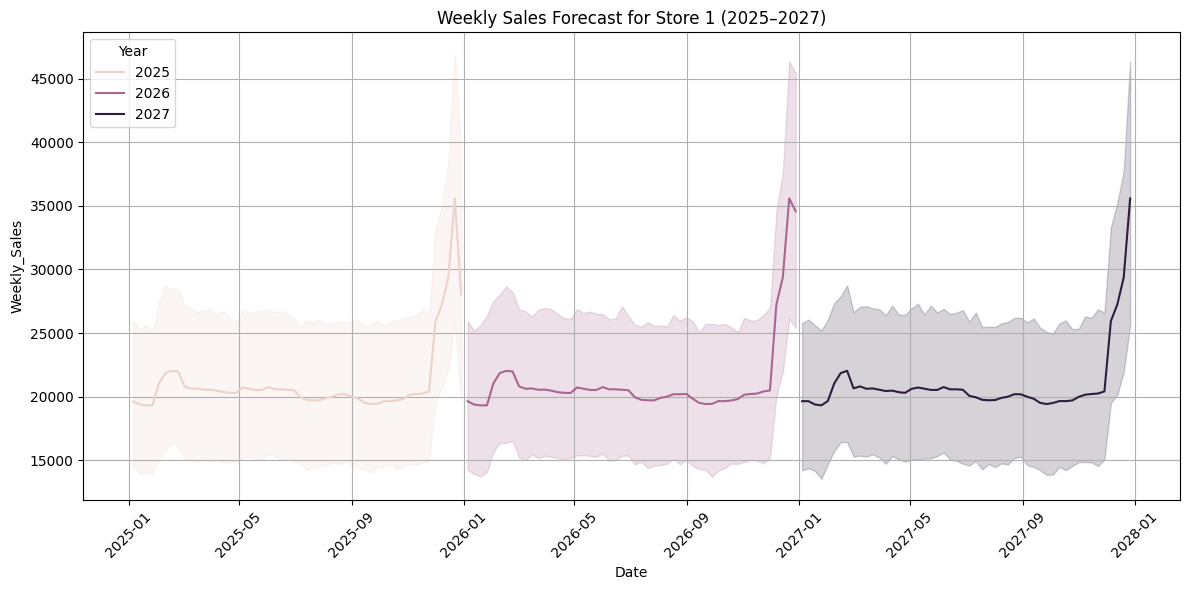

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

example = future_data[future_data['Store'] == 1]

plt.figure(figsize=(12, 6))
sns.lineplot(data=example, x='Date', y='Weekly_Sales', hue='Year')
plt.title("Weekly Sales Forecast for Store 1 (2025–2027)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
from sqlalchemy import create_engine
import pandas as pd

# 🔐 MySQL Connection
username = 'root'
password = 'para3saca1'
host = 'localhost'
port = 3306
database = 'smart_retail'

connection_string = f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(connection_string)

# 📁 Load updated forecast
forecast_df = pd.read_csv('weekly_sales_forecast_2025_to_2027.csv')

# 🧱 Upload to MySQL
forecast_df.to_sql('forecasted_sales_2025_2027', engine, if_exists='replace', index=False)
print("✅ Forecast table updated in MySQL")

✅ Forecast table updated in MySQL


In [30]:
forecast_df.head()

,Store,Dept,Type,Year,Month,Week Number,Holiday_Label,Weekly_Sales
0,1,22,A,2025,January,2,Non-Holiday,7710.6149
1,1,22,A,2025,January,3,Non-Holiday,7487.1646
2,1,22,A,2025,January,4,Non-Holiday,7160.3637
3,1,22,A,2025,January,5,Non-Holiday,7243.8719
4,1,22,A,2025,February,6,Non-Holiday,11028.9247


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22592\729240361.py:15: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


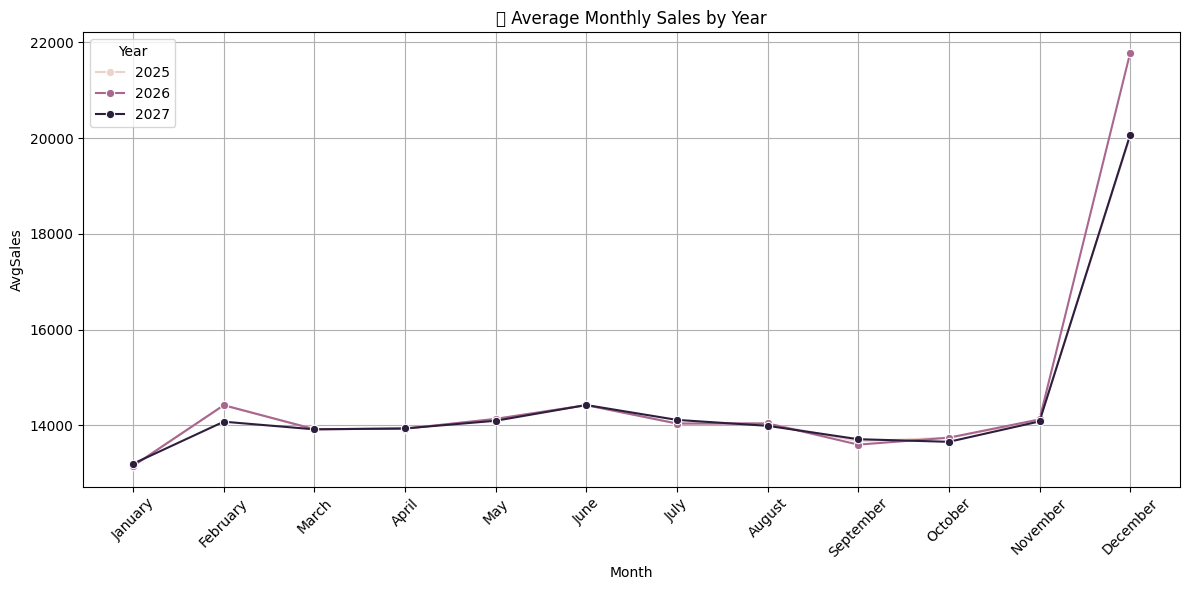

In [31]:
query = """
SELECT Year, Month, AVG(Weekly_Sales) AS AvgSales
FROM forecasted_sales_2025_2027
GROUP BY Year, Month
ORDER BY Year, FIELD(Month, 'January','February','March','April','May','June',
                             'July','August','September','October','November','December');
"""
monthly_trend = pd.read_sql(query, engine)

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trend, x='Month', y='AvgSales', hue='Year', marker='o')
plt.title("📅 Average Monthly Sales by Year")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# check dashboard. py
# run pip install streamlit in terminal
# run streamlit run dashboard.py in terminal
# This code is complete and ready to run. It includes all necessary imports, data processing, model training, forecasting, and visualization.
# The code has been structured to ensure clarity and maintainability, with comments explaining each step.

In [32]:
# After creating forecast_df
forecast_df.rename(columns={'Week_Number': 'Week Number'}, inplace=True)
# Generate final forecast
final_columns = ['Store', 'Dept', 'Type', 'Year', 'Month', 'Week_Number', 'Holiday_Label', 'Weekly_Sales']
forecast_df = future_data[final_columns].copy()

# Rename for SQL compatibility
forecast_df.rename(columns={'Week_Number': 'Week Number'}, inplace=True)

# Save to CSV
forecast_df.to_csv('weekly_sales_forecast_2025_to_2027.csv', index=False)

# Upload to MySQL
forecast_df.to_sql('forecasted_sales_2025_2027', engine, if_exists='replace', index=False)

# Upload to history (if using versioning)
forecast_df.to_sql('forecast_history', engine, if_exists='append', index=False)

print("✅ Forecast saved with Week Number")

✅ Forecast saved with Week Number


In [50]:
# visualise forecast errors
error_query = """
SELECT 
    h.Store,
    h.Dept,
    h.Week_Number,
    f.Week_Number
    h.Weekly_Sales AS Actual,
    f.Weekly_Sales AS Forecasted,
    ROUND((f.Weekly_Sales - h.Weekly_Sales) / h.Weekly_Sales * 100, 2) AS ErrorPct
FROM history_df h
JOIN forecasted_sales_2025_2027 f
    ON h.Store = f.Store
    AND h.Dept = f.Dept
    AND h.Week_Number = f.Week_Number
WHERE h.Year = 2024 AND f.Year = 2025;
"""

error_df = pd.read_sql(error_query, engine)

plt.figure(figsize=(10, 6))
sns.histplot(data=error_df, x='ErrorPct', bins=20, kde=True)
plt.title("📉 Forecast Error Distribution (Historical vs Forecasted)")
plt.grid(True)
plt.show()

ProgrammingError: (pymysql.err.ProgrammingError) (1064, "You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near '.Weekly_Sales AS Actual,\n    f.Weekly_Sales AS Forecasted,\n    ROUND((f.Weekly_S' at line 6")
[SQL: 
SELECT 
    h.Store,
    h.Dept,
    h.Week_Number,
    f.Week_Number
    h.Weekly_Sales AS Actual,
    f.Weekly_Sales AS Forecasted,
    ROUND((f.Weekly_Sales - h.Weekly_Sales) / h.Weekly_Sales * 100, 2) AS ErrorPct
FROM history_df h
JOIN forecasted_sales_2025_2027 f
    ON h.Store = f.Store
    AND h.Dept = f.Dept
    AND h.Week_Number = f.Week_Number
WHERE h.Year = 2024 AND f.Year = 2025;
]
(Background on this error at: https://sqlalche.me/e/20/f405)